In [382]:
import os
import tensorflow as tf

In [383]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

A função, chamada tensor_to_image, converte um tensor para uma imagem, e retorna o objeto de imagem, que pode ser manipulado ou salvo conforme necessário.

In [384]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Baixe imagens e escolha uma imagem de estilo e uma imagem de conteúdo:

In [385]:
content_path = '/content/estilo7.jpg'
style_path = '/content/estilo7.jpg'

## Visualização das imagens de entrada

A função, chamada load_img, carrega uma imagem e limita sua dimensão máxima a 512 pixels.

In [386]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

A função, chamada imshow, exibe uma imagem no display.

In [387]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

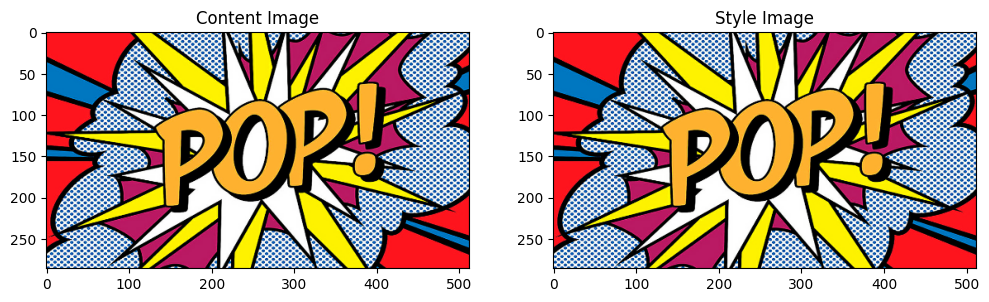

In [388]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Definindo conteúdo e representações de estilo

Utilizamos as camadas intermediárias do modelo para obter as representações de conteúdo e estilo da imagem. A partir da camada de entrada da rede, as primeiras ativações de camada representam recursos de baixo nível, como bordas e texturas. À medida que você percorre a rede, as camadas finais representam recursos de nível superior - partes de objetos como rodas ou olhos. Nesse caso, estamos utilizando a arquitetura de rede VGG19, uma rede de classificação de imagem pré-treinada. Essas camadas intermediárias são necessárias para definir a representação de conteúdo e estilo das imagens. Para uma imagem de entrada, vamos associar o estilo correspondente e as representações de destino de conteúdo nessas camadas intermediárias.


Carregamos um [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) e o testamos em nossa imagem para garantir que seja usado corretamente:

In [389]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [390]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('comic_book', 0.94944334),
 ('book_jacket', 0.013963753),
 ('shield', 0.0088543175),
 ('pillow', 0.0038763743),
 ('tray', 0.003833936)]

Agora carregue um VGG19 sem o cabeçalho de classificação e liste os nomes das camadas

In [391]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_42
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Este modelo contêm apenas os extratores de características, ou seja, as camadas convolucionais e MaxPooling da VGG-19.

Para a escolha de camadas intermediárias da rede para representar o estilo e o conteúdo da imagem, é recomendado a escolha a seguir:

In [392]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Camadas intermediárias para estilo e conteúdo

Então, por que essas saídas intermediárias dentro de nossa rede de classificação de imagens pré-treinadas nos permitem definir representações de estilo e conteúdo?

Em um nível alto, para que uma rede execute a classificação de imagens (para a qual essa rede foi treinada), ela deve entender a imagem. Isso requer tomar a imagem bruta como pixels de entrada e construir uma representação interna que converta os pixels da imagem bruta em uma compreensão complexa dos recursos presentes na imagem.

Essa também é uma razão pela qual as redes neurais convolucionais são capazes de generalizar bem: elas são capazes de capturar as invariâncias e características definidoras dentro de classes (por exemplo, gatos vs. cães) que são agnósticas ao ruído de fundo e outros incômodos. Assim, em algum lugar entre onde a imagem bruta é alimentada no modelo e o rótulo de classificação de saída, o modelo serve como um extrator de recursos complexos. Ao acessar as camadas intermediárias do modelo, você pode descrever o conteúdo e o estilo das imagens de entrada.

## Construindo o modelo

As redes em tf.keras.applications são projetadas para que você possa extrair facilmente os valores da camada intermediária usando a API funcional Keras.

Para definir um modelo usando a API funcional, especifique as entradas e saídas:

model = Model(inputs, outputs)

A função a seguir cria um modelo VGG19 que retorna uma lista de saídas da camada intermediária:

In [393]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

E para criar o modelo:

In [394]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 286, 512, 64)
  min:  0.0
  max:  896.7129
  mean:  55.165237

block2_conv1
  shape:  (1, 143, 256, 128)
  min:  0.0
  max:  6048.426
  mean:  325.72595

block3_conv1
  shape:  (1, 71, 128, 256)
  min:  0.0
  max:  12238.826
  mean:  397.86075

block4_conv1
  shape:  (1, 35, 64, 512)
  min:  0.0
  max:  27746.34
  mean:  1317.6488

block5_conv1
  shape:  (1, 17, 32, 512)
  min:  0.0
  max:  5663.7407
  mean:  93.37687



## Calculo do estilo

O conteúdo de uma imagem é representado pelos valores dos mapas de recursos intermediários.

Acontece que o estilo de uma imagem pode ser descrito pelos meios e correlações entre os diferentes mapas de recursos. Calcule uma matriz Gram que inclua essa informação tomando o produto externo do vetor de características consigo mesmo em cada local e calculando a média desse produto externo em todos os locais. Esta matriz Gram pode ser calculada para uma camada particular como:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$


In [395]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extrair o estilo e o conteúdo


Construção de um modelo que retorne os tensores de estilo e conteúdo.

In [396]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

Quando chamado em uma imagem, este modelo retorna a matriz grama (estilo) do style_layers e o conteúdo do content_layers :

In [397]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.24866891
    max:  38044.688
    mean:  3054.2502

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  954490.5
    mean:  107140.41

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  3760655.2
    mean:  156035.86

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  39440028.0
    mean:  1510516.6

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  661371.8
    mean:  7014.526

Contents:
   block5_conv2
    shape:  (1, 17, 32, 512)
    min:  0.0
    max:  1807.6354
    mean:  33.20903


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [398]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [399]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [400]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:

In [401]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [402]:
style_weight=1e-2
content_weight=1e4

In [403]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [404]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

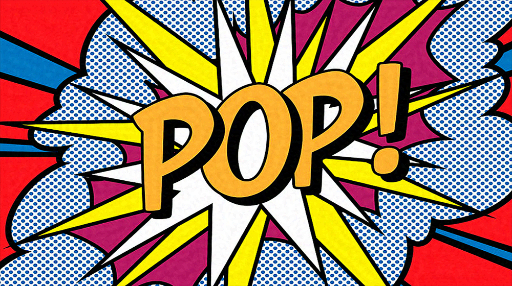

In [405]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

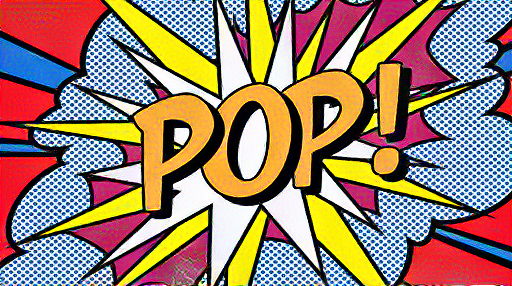

Train step: 1000
Total time: 51.2


In [406]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [407]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

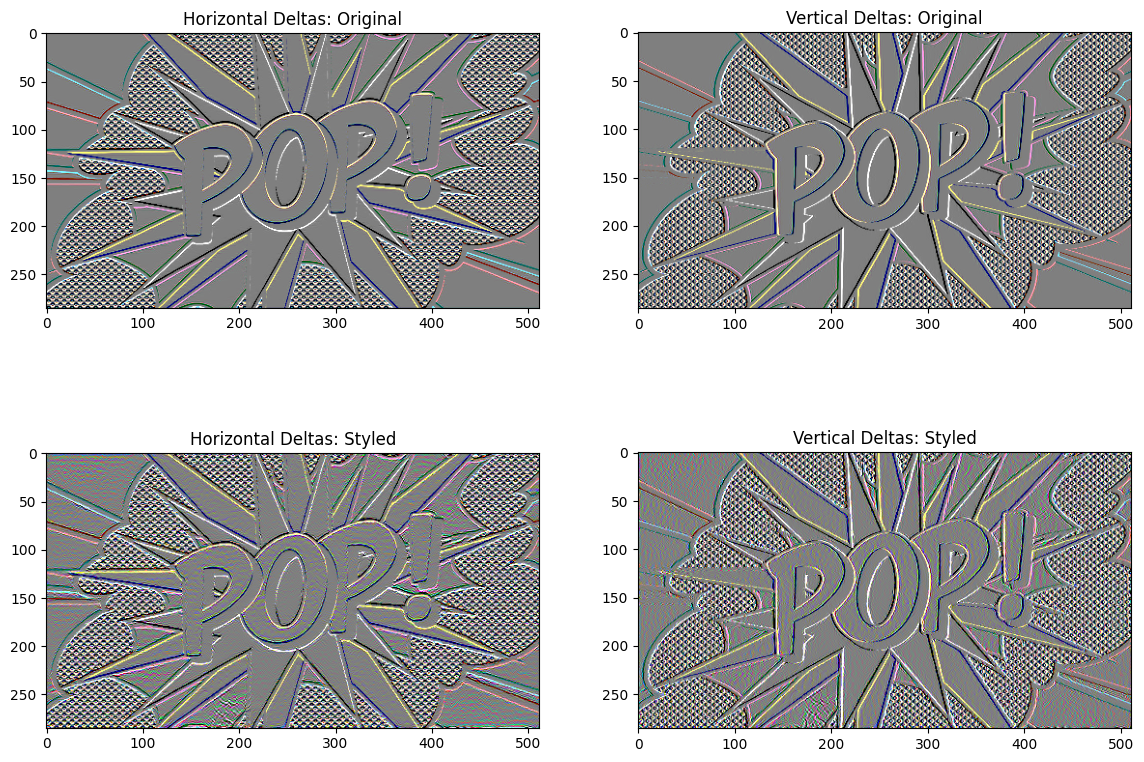

In [408]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [409]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [410]:
total_variation_loss(image).numpy()

101827.484

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [411]:
total_variation_weight=30

Now include it in the `train_step` function:

In [412]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the image-variable and the optimizer:

In [413]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

And run the optimization:

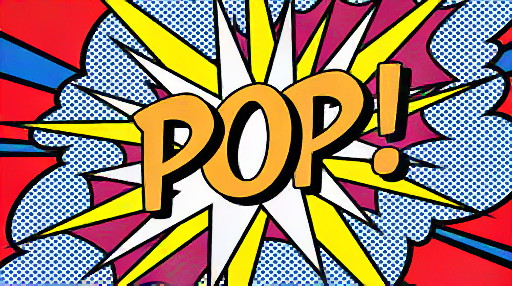

Train step: 1000
Total time: 54.3


In [414]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [415]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>